# Convergence of the error
In this notebook, we test the theoretical orders of convergence for the Poisson problem
$$
\begin{aligned}
-\Delta u &= f \quad\text{in }\Omega\\
u &= g_D \quad\text{on }\Gamma_D\\
\nabla u\cdot n &= g_N \quad\text{on }\Gamma_N.
\end{aligned}
$$
Given a mesh with characteristic element size $h$ and a FE space of piecewise polynomial functions of degree $p$, we expect that the error between the FE solution $u_h$ and the exact one $u$ behaves as follows: there exists a constant $C>0$ such that
$$
\left(\int_\Omega (u-u_h)^2 \right)^{1/2}\leq C h^{p+1}
$$
and 
$$
\left(\int_\Omega (\nabla u-\nabla u_h)^2\right)^{1/2} \leq C h^{p}.
$$
The two bounds above are true  *provided that the function $u$ has at least $p+1$ square-integrable derivatives* (i.e., that the function is sufficiently regular), *otherwise the order of convergence is reduced*. 

The first is called the $L^2$ norm of the error, while the second one is the $H^1_0$ (or energy) norm.

We will use the tehcnique of "manifactured solution": we choose a specific function on the square $(0,1)^2$
$$
u(x, y)= \sin(\pi x)\sin(\pi y)
$$
and derive the right hand $f$ so that $u$ is a solution to the Poisson problem. We obtain that $u$ solves, for example, the problem
$$
\begin{aligned}
-(\Delta u)(x, y) = 2\pi^2\sin(\pi x)\sin(\pi y) \qquad &\text{in }(0,1)^2\\
u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0 \qquad &\text{per }x, y\in(0,1)
\end{aligned}
$$

In the following, we solve this problem for different grids and different polynomial degrees, then we compare the FE solution with the exact one above.


In [12]:
from mpi4py import MPI
from petsc4py.PETSc import ScalarType

In [13]:
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot 
from dolfinx.fem import Expression, Function, form, assemble_scalar
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner
import matplotlib.pyplot as plt
import pandas as pd


After the imports, we create a function that solves the Poisson problem, as in the other notebooks. It takes as an input the number of refinements per edge of the domain and the polynomial degree. 

In [14]:
def solve_problem(n_el, p):
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((0., 0), (1.0, 1.0)),
        n=[n_el]*2,
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", p))
    facets = mesh.locate_entities_boundary(
        msh,
        dim=(msh.topology.dim - 1),
        marker=lambda x: np.isclose(x[0], 0) | np.isclose(x[0], 1) | np.isclose(x[1], 0) | np.isclose(x[1], 1.),
    )
    dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
    bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    x = ufl.SpatialCoordinate(msh)
    f = 2 * np.pi**2 * ufl.sin(np.pi*x[0]) * ufl.sin(np.pi*x[1])

    a = inner(grad(u), grad(v)) * dx
    L = inner(f, v) * dx 
    problem = LinearProblem(a, L, bcs=[bc], petsc_options_prefix="poisson_error",
                            petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()

    return uh


We now write two functions that compute the two types of the error, that we have defined above.

In [15]:
def L2_error(uh, u_ex):
    error = form((uh - u_ex)**2 * ufl.dx)
    E = np.sqrt(assemble_scalar(error))
    return E

def H1_error(uh, u_ex):
    error = form((ufl.grad(uh) - ufl.grad(u_ex))**2 * ufl.dx)
    E = np.sqrt(assemble_scalar(error))
    return E


We then compute the errors, for different grid sizes and for a fixed polynomial degree, here $p=1$. We consider different grids, starting with 4 elements per side of the domain, and adding 10 elements per side at each refinement. 

In [16]:
p = 1
Ns = range(4, 104, 10)
L2err = np.zeros(len(Ns))
H1err = np.zeros(len(Ns))
h = np.zeros(len(Ns))

for i, n in enumerate(Ns):
    uh = solve_problem(n, p)
    msh = uh.function_space.mesh
    x = ufl.SpatialCoordinate(msh)
    u_ex = ufl.sin(np.pi*x[0]) * ufl.sin(np.pi*x[1])
    L2err[i] = L2_error(uh, u_ex)
    H1err[i] = H1_error(uh, u_ex)
    h[i] = 1./n

We now want to plot the behaviour of the errors with respect to the grid size. We start by doing this on a linear-linear plot. We invert the ordinate axis to show the error going down for smaller mesh sizes.

Text(0.5, 0, '$h$')

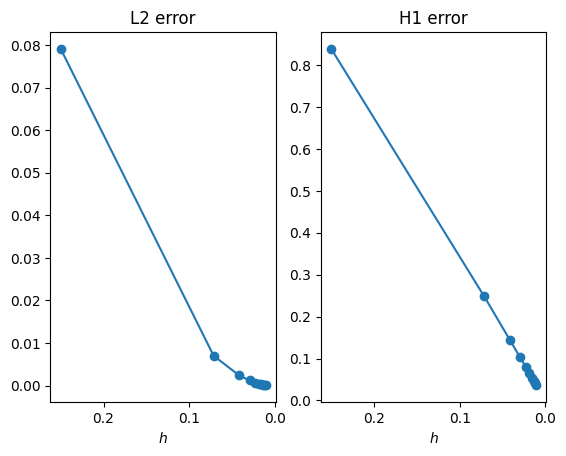

In [17]:
_, ax = plt.subplots(1, 2)
ax[0].plot(h, L2err, '-o')
ax[0].invert_xaxis()
ax[0].set_title('L2 error')
ax[0].set_xlabel('$h$')
ax[1].plot(h, H1err, '-o')
ax[1].invert_xaxis()
ax[1].set_title('H1 error')
ax[1].set_xlabel('$h$')

In the plot above, it is hard to properly see the rate of convergence. We redo the plot in the $\log-\log$ scale.

Text(0.5, 0, '$h$')

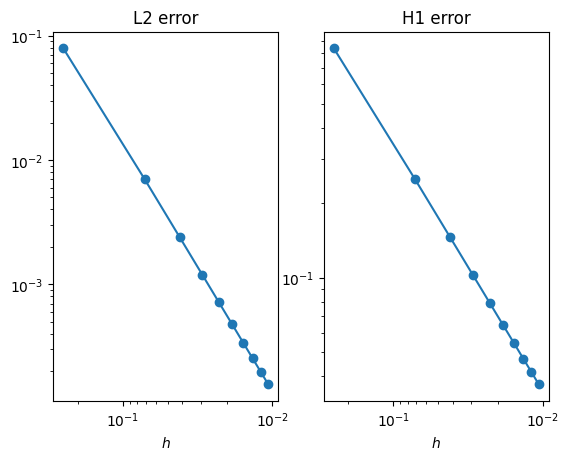

In [18]:
_, ax = plt.subplots(1, 2)
ax[0].loglog(h, L2err, '-o')
ax[0].invert_xaxis()
ax[0].set_title('L2 error')
ax[0].set_xlabel('$h$')
ax[1].loglog(h, H1err, '-o')
ax[1].invert_xaxis()
ax[1].set_title('H1 error')
ax[1].set_xlabel('$h$')

We now exploit the fact that, if, for some $C, r>0$ independent of $h$
$$ 
\mathrm{e}(h) = C h^{r}
$$
then 
$$
\log(e(h)) = \log(C) + r \log(h),
$$
which implies that an error curve will show up as a line with slope $r$ in $\log-\log$ scale. We first estimate our computational orders of convergence: we don't know the value of $C$, but we have that, if the equation above for the error is satisfied, for two values $h_i, h_j$,
$$
\log(e(h_i)) - \log(e(h_j)) = r \left[\log(h_i) - \log(h_j)\right].
$$
We use this equation to estimate the value of $r$.

In [19]:
L2r_est = np.divide(np.diff(np.log(L2err)), np.diff(np.log(h)))
H1r_est = np.divide(np.diff(np.log(H1err)), np.diff(np.log(h)))

df = pd.DataFrame({
    "L2 rate": L2r_est, 
    "H1 rate": H1r_est
})
df

,L2 rate,H1 rate
0,1.934091,0.971094
1,1.990415,0.995947
2,1.996135,0.998373
3,1.997907,0.999120
4,1.998686,0.999448
5,1.999098,0.999621
6,1.999343,0.999724
7,1.999499,0.999790
8,1.999606,0.999835


We now plot the theoretical estimate as a straight line alongside the errors that we computed, in the $\log-\log$ scale.

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_851/1507568822.py:5: SyntaxWarning: invalid escape sequence '\p'
  ax[0].loglog(h, L2th, '--', label=f"$\propto h^{p+1}$")
/tmp/ipykernel_851/1507568822.py:11: SyntaxWarning: invalid escape sequence '\p'
  ax[1].loglog(h, H1th, '--', label=f"$\propto h^{p}$")


Text(0.5, 0, '$h$')

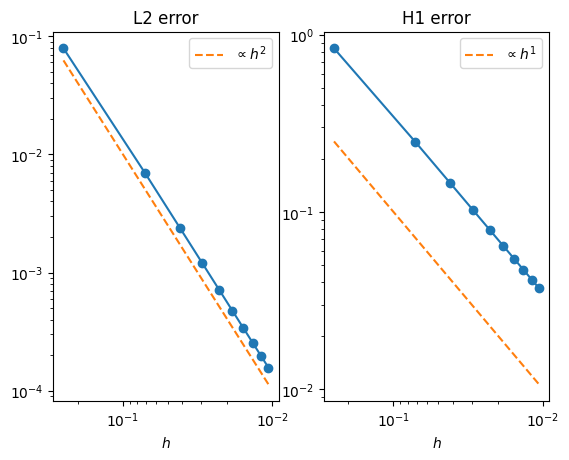

In [20]:
L2th = h**(p+1)
H1th = h**p 
_, ax = plt.subplots(1, 2)
ax[0].loglog(h, L2err, '-o')
ax[0].loglog(h, L2th, '--', label=f"$\propto h^{p+1}$")
ax[0].invert_xaxis()
ax[0].set_title('L2 error')
ax[0].set_xlabel('$h$')
ax[0].legend()
ax[1].loglog(h, H1err, '-o')
ax[1].loglog(h, H1th, '--', label=f"$\propto h^{p}$")
ax[1].invert_xaxis()
ax[1].legend()
ax[1].set_title('H1 error')
ax[1].set_xlabel('$h$')

We now repeat this whole procedure for a different polynomial degree $p=3$.

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_851/3530690599.py:20: SyntaxWarning: invalid escape sequence '\p'
  ax[0].loglog(h, L2th, '--', label=f"$\propto h^{p+1}$")
/tmp/ipykernel_851/3530690599.py:26: SyntaxWarning: invalid escape sequence '\p'
  ax[1].loglog(h, H1th, '--', label=f"$\propto h^{p}$")


Text(0.5, 0, '$h$')

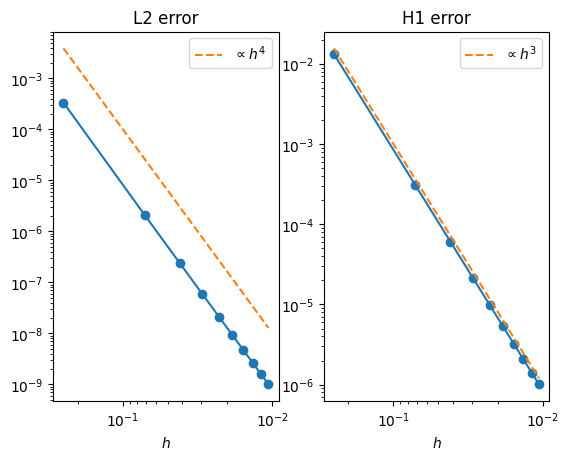

In [21]:
p = 3 
Ns = range(4, 104, 10)
L2err = np.zeros(len(Ns))
H1err = np.zeros(len(Ns))
h = np.zeros(len(Ns))

for i, n in enumerate(Ns):
    uh = solve_problem(n, p)
    msh = uh.function_space.mesh
    x = ufl.SpatialCoordinate(msh)
    u_ex = ufl.sin(np.pi*x[0]) * ufl.sin(np.pi*x[1])
    L2err[i] = L2_error(uh, u_ex)
    H1err[i] = H1_error(uh, u_ex)
    h[i] = 1./n

L2th = h**(p+1)
H1th = h**p 
_, ax = plt.subplots(1, 2)
ax[0].loglog(h, L2err, '-o')
ax[0].loglog(h, L2th, '--', label=f"$\propto h^{p+1}$")
ax[0].invert_xaxis()
ax[0].set_title('L2 error')
ax[0].set_xlabel('$h$')
ax[0].legend()
ax[1].loglog(h, H1err, '-o')
ax[1].loglog(h, H1th, '--', label=f"$\propto h^{p}$")
ax[1].invert_xaxis()
ax[1].legend()
ax[1].set_title('H1 error')
ax[1].set_xlabel('$h$')

In [22]:
L2r_est = np.divide(np.diff(np.log(L2err)), np.diff(np.log(h)))
H1r_est = np.divide(np.diff(np.log(H1err)), np.diff(np.log(h)))

df = pd.DataFrame({
    "L2 rate": L2r_est, 
    "H1 rate": H1r_est
})
df

,L2 rate,H1 rate
0,4.058363,3.001597
1,4.023326,3.004553
2,4.014140,3.003256
3,4.010108,3.002504
4,4.007855,3.002030
5,4.006419,3.001705
6,4.005426,3.001470
7,4.004697,3.001292
8,4.004140,3.001152
